# Generating counterfactual explanations with any ML model

The goal of this notebook is to show how to generate CFs for ML models using frameworks other than TensorFlow or PyTorch. This is a work in progress and here we show a method to generate diverse CFs by three methods: 
1. Independent random sampling of features
2. Genetic algorithm
3. Querying a KD tree

We use scikit-learn models for demonstration.  

# 1. Independent random sampling of features

In [1]:
# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
%load_ext autoreload
%autoreload 2

## Loading dataset

We use the "adult" income dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). For demonstration purposes, we transform the data as described in dice_ml.utils.helpers module.

In [3]:
dataset = helpers.load_adult_income_dataset()

In [4]:
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [5]:
d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

## Training a custom ML model

Below, we build an ML model using scikit-learn to demonstrate how our methods can work with any sklearn model. 

In [6]:
target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

In [7]:
# provide the trained ML model to DiCE's model object
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

## Generate diverse counterfactuals

In [113]:
from dice_ml import Dice

from dice_ml.counterfactual_explanations import CounterfactualExplanations
import dice_ml

import pandas as pd




class CounterFactuals:
    def __init__(self, exp: Dice, desired: str):
        self.exp = exp

        self.outcome_name = exp.data_interface.outcome_name
        self.desired = desired
        self.model_type = exp.model.model_type

        self.classifier = 'classifier'
        self.regressor = 'regressor'

        self.is_classifier = self.model_type == self.classifier

        self.exp_random = dice_ml.Dice(self.exp.data_interface, self.exp.model, method = "random")


    def generate_counterfactuals(self, query_instances: pd.DataFrame, total_CFs: int = 2,
                                 permitted_range = None, features_to_vary = 'all', #feature_weights = None,
                                 proximity_weight: float = 0.5, diversity_weight: float = 1.0) -> CounterfactualExplanations:
        '''
            Some features might be harder to change relative to others. You can use features_weights (default of DICE is inverse MAD from training data)
            The higher a weight, the more difficult is the corresponding feature to change.
            Check section 2 of http://interpret.ml/DiCE/notebooks/DiCE_with_advanced_options.html
        '''

        desired_range, desired_class = self.get_range(self.desired)
        
        result = self.exp.generate_counterfactuals(query_instances = query_instances, total_CFs = total_CFs, desired_range = desired_range,
                desired_class = desired_class, permitted_range = permitted_range, 
                features_to_vary = features_to_vary, #feature_weights = feature_weights,
                proximity_weight = proximity_weight, diversity_weight = diversity_weight)

        return result

    def get_range(self, desired):
        if self.is_classifier:
            desired_range = None, 
            desired_class = desired
        else:
            desired_range = desired 
            desired_class = None
        return desired_range, desired_class


    def necessity(self, feature, query_instances: pd.DataFrame, total_CFs: int = 2,
                                 permitted_range = None, random_seed = 42):#feature_weights = None):
        '''
        Eq. (8) of 2011.04917v3
        '''

        result = self.exp_random.generate_counterfactuals(query_instances = query_instances, total_CFs = total_CFs, 
                    permitted_range = permitted_range, 
                    features_to_vary = [feature], random_seed = random_seed)

        #NOTE: SHOULD FILTER I THINK
        
        
        numerator, totalN = self.get_number_valid_cfs(result.cf_examples_list)
        
        N = totalN #number of query instances with CFs
        denominator = N*total_CFs

        number = numerator/denominator

        return number

    def get_number_valid_cfs(self, lista, verbose = True):
        #Unique CFs
        
        numerator = 0
        totalN = 0
        for example in lista:
            if example.final_cfs_df is not None:
                data = example.final_cfs_df.values.tolist()
                unique_data = [list(x) for x in set(tuple(x) for x in data)]
                numerator += len(unique_data)
            totalN += 1
                
        if verbose:
            print('Total number of considered instances for which we have CFs for necessity/sufficiency', totalN, f'out of {len(lista)}')
        return numerator, totalN

    def sufficiency(self, feature, query_instances: pd.DataFrame, total_CFs: int = 2,
                                 permitted_range = None, random_seed = 42): #feature_weights = None):
        '''
        Eq. (9) of 2011.04917v3
        '''

        result_all = self.exp_random.generate_counterfactuals(query_instances = query_instances, total_CFs = total_CFs, 
                    permitted_range = permitted_range, 
                    features_to_vary = 'all', random_seed = random_seed)

        features_list = list(query_instances.columns.difference([feature]))

        result_fixed = self.exp_random.generate_counterfactuals(query_instances = query_instances, total_CFs = total_CFs, 
                    permitted_range = permitted_range, 
                    features_to_vary = [feature], random_seed = random_seed)

        numerator_all, totalN_all = self.get_number_valid_cfs(result_all.cf_examples_list)
        numerator_fixed, totalN_fixed = self.get_number_valid_cfs(result_fixed.cf_examples_list)
        print('DIFF', numerator_all)
        print('DIFF', numerator_fixed)
        numerator = numerator_all-numerator_fixed
        print('DIFF', numerator)
        
        N = len(query_instances.index)
        denominator = N*total_CFs

        number = numerator/denominator
        
        print(feature, number)

        return number

In [114]:
# initiate DiCE
exp_random = dice_ml.Dice(d, m, method = "random")

In [115]:
C = CounterFactuals(exp_random, 'opposite')

In [116]:
all_vars = x_train.columns

In [120]:
query_instances = x_train[:10]
results_necessity = []
results_sufficiency = []
for v in all_vars:
    results_necessity += [C.necessity(v, query_instances, total_CFs = 4)]
    results_sufficiency += [C.sufficiency(v, query_instances, total_CFs = 4)]

 30%|███       | 3/10 [00:00<00:01,  5.82it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 5/10 [00:00<00:00,  5.53it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:01<00:00,  4.77it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 40%|████      | 4/10 [00:00<00:01,  5.85it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  6.69it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:01<00:00,  6.07it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 2/10 [00:00<00:00, 14.12it/s]

Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 34
DIFF 6
age 0.15
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00, 11.93it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 12.14it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 20%|██        | 2/10 [00:00<00:00, 15.90it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00, 10.40it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 70%|███████   | 7/10 [00:00<00:00,  9.02it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 5
DIFF 35
workclass 0.875


 20%|██        | 2/10 [00:00<00:01,  5.53it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  7.41it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:01<00:00,  8.81it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 20%|██        | 2/10 [00:00<00:01,  6.02it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00,  7.51it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  8.59it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:01<00:00,  9.75it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 13
DIFF 27
education 0.675
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00, 10.22it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 10.39it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00,  8.80it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 10.21it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 10%|█         | 1/10 [00:00<00:01,  7.47it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 12
DIFF 28
marital_status 0.7
Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 3/10 [00:00<00:00, 11.22it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  8.99it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:00<00:00, 11.32it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 30%|███       | 3/10 [00:00<00:00, 11.41it/s]

Only 2 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 50%|█████     | 5/10 [00:00<00:00, 10.60it/s]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 9/10 [00:00<00:00, 11.98it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 2/10 [00:00<00:00, 12.18it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 9
DIFF 31
occupation 0.775
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00, 12.32it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 14.02it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 20%|██        | 2/10 [00:00<00:00,  9.65it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00, 12.09it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 12.48it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 2/10 [00:00<00:00, 12.37it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 3
DIFF 37
race 0.925
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00, 13.06it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 14.21it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 20%|██        | 2/10 [00:00<00:00, 12.83it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00, 12.93it/s]

Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 4)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 3
DIFF 37
gender 0.925


 20%|██        | 2/10 [00:00<00:00,  9.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  9.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


  0%|          | 0/10 [00:00<?, ?it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10


 20%|██        | 2/10 [00:00<00:00,  9.17it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 40%|████      | 4/10 [00:00<00:00,  9.14it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 6/10 [00:00<00:00,  9.28it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00,  9.11it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]

Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
Total number of considered instances for which we have CFs for necessity/sufficiency 10 out of 10
DIFF 40
DIFF 24
DIFF 16
hours_per_week 0.4


In [121]:
import matplotlib.pyplot as plt

In [122]:
results_necessity

[0.85, 0.125, 0.325, 0.3, 0.225, 0.075, 0.075, 0.6]

In [123]:
1-results_sufficiency[0]

0.85

<BarContainer object of 8 artists>

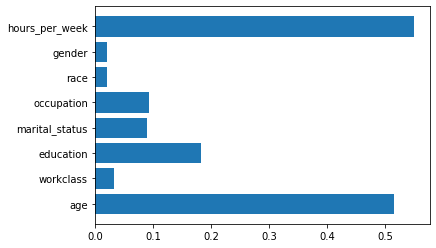

In [83]:
plt.barh(all_vars, results_necessity)

<BarContainer object of 8 artists>

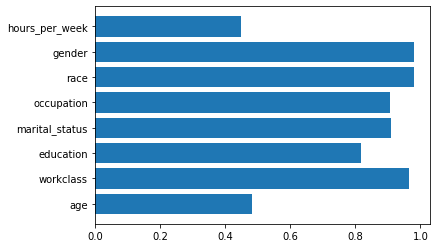

In [94]:
plt.barh(all_vars, results_sufficiency)

In [ ]:
results_sufficiency

In [86]:
C.necessity('occupation', query_instances, total_CFs = 10)

  7%|▋         | 2/30 [00:00<00:03,  7.87it/s]

Only 2 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 20%|██        | 6/30 [00:00<00:02,  8.77it/s]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 30%|███       | 9/30 [00:01<00:02,  9.70it/s]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 37%|███▋      | 11/30 [00:01<00:02,  8.77it/s]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 43%|████▎     | 13/30 [00:01<00:01, 10.10it/s]

Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 53%|█████▎    | 16/30 [00:01<00:01,  8.67it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 60%|██████    | 18/30 [00:01<00:01, 10.66it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 73%|███████▎  | 22/30 [00:02<00:00, 11.73it/s]

Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 24/30 [00:02<00:00, 10.48it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 3 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 90%|█████████ | 27/30 [00:02<00:00,  8.35it/s]

Only 5 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Only 1 (required 10)  Diverse Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 30/30 [00:03<00:00,  9.55it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
Total number of considered instances for which we have CFs for necessity/sufficiency 30 out of 30


0.09333333333333334

In [11]:
m

In [12]:
exp_random.model

In [29]:
query_instances = x_train[4:6]

In [30]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=2, desired_class="opposite", verbose=False)


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


In [31]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,27,Private,School,Single,Blue-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,61.0,-,Assoc,-,-,-,-,-,1
1,53.0,-,Assoc,-,-,-,-,-,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,31,Self-Employed,Some-college,Married,Sales,Other,Male,60,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,-,Divorced,-,-,-,28.0,0
1,46.0,-,Assoc,-,-,-,-,-,0


It can be observed that the random sampling method produces less sparse CFs in contrast to current DiCE's implementation. The sparsity issue with random sampling worsens with increasing *total_CFs* 

Further, different sets of counterfactuals can be generated with different random seeds.

In [32]:
# generate counterfactuals
# default random seed is 17
dice_exp_random = exp_random.generate_counterfactuals(query_instances,
                                                      total_CFs=4,
                                                      desired_class="opposite",
                                                      random_seed=9)

100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


In [33]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,27,Private,School,Single,Blue-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,87.0,-,Assoc,-,-,-,-,-,1
1,67.0,-,Assoc,-,-,-,-,-,1
2,61.0,-,Assoc,-,-,-,-,-,1
3,72.0,-,Assoc,-,-,-,-,-,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,31,Self-Employed,Some-college,Married,Sales,Other,Male,60,1



Diverse Counterfactual set (new outcome: 0.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,-,-,-,-,Female,24.0,0
1,44.0,-,-,Separated,-,-,-,-,0
2,-,Other/Unknown,-,-,Blue-Collar,-,-,-,0
3,-,-,-,-,-,-,-,20.0,0


### Selecting the features to vary

Here, you can ensure that DiCE varies only features that it makes sense to vary.

In [43]:
query_instances = x_train[4:5]

In [44]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
        query_instances, total_CFs=4, desired_class="opposite",
        features_to_vary=['age'])

100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


In [49]:
dice_exp_random.cf_examples_list[0].final_cfs_df

In [45]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,27,Private,School,Single,Blue-Collar,White,Male,40,0



No counterfactuals found!


### Choosing feature ranges

Since the features are sampled randomly, they can freely vary across their range. In the below example, we show how range of continuous features can be controlled using *permitted_range* parameter that can now be passed during CF generation.

In [ ]:
# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})

In [ ]:
dice_exp_random.visualize_as_dataframe(show_only_changes=True)

# 2. Genetic Algorithm

Here, we show how to use DiCE can be used to generate CFs for any ML model by using the genetic algorithm to find the best counterfactuals close to the query point. The genetic algorithm converges quickly, and promotes diverse counterfactuals. 

## Training a custom ML model

Currently, the genetic algorithm method works with scikit-learn models. We will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.

## Generate diverse counterfactuals

In [14]:
# initiate DiceGenetic
exp_genetic = dice_ml.Dice(d, m, method='genetic')

In [18]:
# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances, total_CFs=4, desired_class='opposite', verbose=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Initializing initial parameters to the genetic algorithm...
Initialization complete! Generating counterfactuals...


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Diverse Counterfactuals found! total time taken: 00 min 02 sec
Initializing initial parameters to the genetic algorithm...
Initialization complete! Generating counterfactuals...


100%|██████████| 2/2 [00:23<00:00, 11.66s/it]

Only 3 (required 4)  Diverse Counterfactuals found for the given configuation, perhaps  change the query instance or the features to vary...; total time taken: 00 min 20 sec


In [20]:
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,27,Private,School,Single,Blue-Collar,White,Male,40,0



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,Assoc,Married,White-Collar,-,-,-,1
0,-,-,Bachelors,Married,Sales,-,-,-,1
0,28.0,-,Assoc,Married,-,-,-,-,1
0,26.0,-,Bachelors,Married,-,-,-,-,1


Query instance (original outcome : 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,31,Self-Employed,Some-college,Married,Sales,Other,Male,60,1



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,-,-,-,-,-,-,-,-,-
0,-,-,-,-,Blue-Collar,White,-,-,-
0,-,-,-,-,White-Collar,-,-,57.0,-


We can also ensure that the genetic algorithm also only varies the features that you wish to vary

In [ ]:
# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class=0,
    features_to_vary=['workclass', 'education', 'occupation', 'hours_per_week'])
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

You can also constrain the features to vary only within the permitted range

In [ ]:
# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class=0,
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

# 3. Querying a KD Tree

Here, we show how to use DiCE can be used to generate CFs for any ML model by finding the closest points in the dataset that give the output as the desired class. We do this efficiently by building KD trees for each class, and querying the KD tree of the desired class to find the k closest counterfactuals from the dataset. The idea behind finding the closest points from the training data itself is to ensure that the counterfactuals displayed are feasible.

## Training a custom ML model

Currently, the KD tree algorithm method works with scikit-learn models. Again, we will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.

## Generate diverse counterfactuals

In [ ]:
# initiate DiceKD
exp_KD = dice_ml.Dice(d, m, method='kdtree')

In [ ]:
# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite")

In [ ]:
dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

### Selecting the features to vary

Here, again, you can vary only features that you wish to vary. Please note that the output counterfactuals are only from the training data. If you want other counterfactuals, please use the random or genetic method. 

In [ ]:
# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    features_to_vary=['age', 'workclass', 'education', 'occupation', 'hours_per_week'])

In [ ]:
dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

### Selecting the feature ranges

Here, you can control the ranges of continuous features. 

In [ ]:
# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=5, desired_class="opposite",
    permitted_range={'age': [30, 50], 'hours_per_week': [40, 60]})
dice_exp_KD.visualize_as_dataframe(show_only_changes=True)